In [1]:
from typing import List


from Project import Project

from ortools.linear_solver import pywraplp


In [2]:
#data
days = 5
slots_per_day = 4
nb_resources = 3
nb_projects = 4

requested_slots_per_project = [4,5,3,4] # TODO generate better data

#create projects
projects: List[Project] = []
for i in range(nb_projects):
    projects.append(Project(i, requested_slots_per_project[i]))


squash_factor= 1


total_time_slots = days * slots_per_day

In [157]:
# Create the MIP solver
solver = pywraplp.Solver.CreateSolver('SCIP') # MIXED_INTEGER_PROGRAMMING

In [158]:
# variables definition

X = {}
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            X[(p, r, t)] = solver.BoolVar(f"X_p{p}_r{r}_t{t}")
S = {}
F = {}
for p in range(nb_projects):
    S[(p)] = solver.IntVar(0, total_time_slots, f"S_p{p}")
    F[(p)] = solver.IntVar(0, total_time_slots, f"F_p{p}")

Y = solver.IntVar(0, total_time_slots, f"Y")
print(X)

{(0, 0, 0): X_p0_r0_t0, (0, 0, 1): X_p0_r0_t1, (0, 0, 2): X_p0_r0_t2, (0, 0, 3): X_p0_r0_t3, (0, 0, 4): X_p0_r0_t4, (0, 0, 5): X_p0_r0_t5, (0, 0, 6): X_p0_r0_t6, (0, 0, 7): X_p0_r0_t7, (0, 0, 8): X_p0_r0_t8, (0, 0, 9): X_p0_r0_t9, (0, 0, 10): X_p0_r0_t10, (0, 0, 11): X_p0_r0_t11, (0, 0, 12): X_p0_r0_t12, (0, 0, 13): X_p0_r0_t13, (0, 0, 14): X_p0_r0_t14, (0, 0, 15): X_p0_r0_t15, (0, 0, 16): X_p0_r0_t16, (0, 0, 17): X_p0_r0_t17, (0, 0, 18): X_p0_r0_t18, (0, 0, 19): X_p0_r0_t19, (0, 1, 0): X_p0_r1_t0, (0, 1, 1): X_p0_r1_t1, (0, 1, 2): X_p0_r1_t2, (0, 1, 3): X_p0_r1_t3, (0, 1, 4): X_p0_r1_t4, (0, 1, 5): X_p0_r1_t5, (0, 1, 6): X_p0_r1_t6, (0, 1, 7): X_p0_r1_t7, (0, 1, 8): X_p0_r1_t8, (0, 1, 9): X_p0_r1_t9, (0, 1, 10): X_p0_r1_t10, (0, 1, 11): X_p0_r1_t11, (0, 1, 12): X_p0_r1_t12, (0, 1, 13): X_p0_r1_t13, (0, 1, 14): X_p0_r1_t14, (0, 1, 15): X_p0_r1_t15, (0, 1, 16): X_p0_r1_t16, (0, 1, 17): X_p0_r1_t17, (0, 1, 18): X_p0_r1_t18, (0, 1, 19): X_p0_r1_t19, (0, 2, 0): X_p0_r2_t0, (0, 2, 1): X_p0_

In [159]:
print("Number of variables =", solver.NumVariables())


Number of variables = 249


In [160]:
# Define the objective function
objective = solver.Objective()
objective.SetCoefficient(Y, 1)
objective.SetMinimization()


In [161]:
# constraint 1
# Define constraint: Total working time for each project respect the request
for p in range(nb_projects):
    solver.Add(sum(X[(p, r, t)] for r in range(nb_resources) for t in range(total_time_slots)) == projects[p].requested_slots)

# constraint 2
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            solver.Add(t * X[(p, r, t)] <= F[p])

# constraint 3
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            solver.Add(S[p] <= t*X[(p, r, t)]+(1-X[(p, r, t)])*99*total_time_slots)

# constraint 4
# constraint assign lower bound of y
for r in range(nb_resources):
    for p in range(nb_projects):
        for t in range(total_time_slots):
            solver.Add(t * X[(p, r, t)] <= Y)

# constraint 5
for p in range(nb_projects):
    solver.Add(F[p]-S[p]+1 <= projects[p].requested_slots*squash_factor)

# constraint 6
# constraints no double booking
for r in range(nb_resources):
    for t in range(total_time_slots):
        solver.Add(sum(X[(p, r, t)] for p in range(nb_projects)) <= 1)

In [162]:
print(solver.NumConstraints())

628


In [163]:
solver.Solve()

0

In [164]:
print('Objective value =', solver.Objective().Value())
for p in range(nb_projects):
    print(f"project {p} : S", S[p].solution_value(), " F:",F[p].solution_value())

print('Y =', Y.solution_value())


# show all the assignation
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            if(X[(p, r, t)].solution_value() == 1.0):
                print("project: ", p, "resource:", r, " time:",t)

Objective value = 5.0
project 0 : S 2.0  F: 5.0
project 1 : S 1.0  F: 5.0
project 2 : S 5.0  F: 7.0
project 3 : S 0.0  F: 3.0
Y = 5.0
project:  0 resource: 1  time: 0
project:  0 resource: 1  time: 2
project:  0 resource: 1  time: 4
project:  0 resource: 1  time: 5
project:  1 resource: 0  time: 2
project:  1 resource: 0  time: 4
project:  1 resource: 0  time: 5
project:  1 resource: 1  time: 1
project:  1 resource: 1  time: 3
project:  2 resource: 0  time: 0
project:  2 resource: 0  time: 1
project:  2 resource: 0  time: 3
project:  3 resource: 2  time: 0
project:  3 resource: 2  time: 1
project:  3 resource: 2  time: 2
project:  3 resource: 2  time: 3


In [165]:
import numpy as np
import pandas as pd

np_array = np.zeros((nb_projects, nb_resources, total_time_slots))

# Populate the array with the values of the decision variables
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            if(X[(p, r, t)].solution_value() == 1.0):
                np_array[p, r, t] = 1

# cut the extra slot that are not used
max_time_slot = int(Y.solution_value())

sliced_array = np_array[:, :, :max_time_slot+1]

reshaped_array = sliced_array.reshape(nb_projects * nb_resources, max_time_slot+1)

df = pd.DataFrame(reshaped_array)
df.index = [0, 1, 2]*4 # define the lef header

print(df)


     0    1    2    3    4    5
0  0.0  0.0  0.0  0.0  0.0  0.0
1  1.0  0.0  1.0  0.0  1.0  1.0
2  0.0  0.0  0.0  0.0  0.0  0.0
0  0.0  0.0  1.0  0.0  1.0  1.0
1  0.0  1.0  0.0  1.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0
0  1.0  1.0  0.0  1.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0
0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0
2  1.0  1.0  1.0  1.0  0.0  0.0


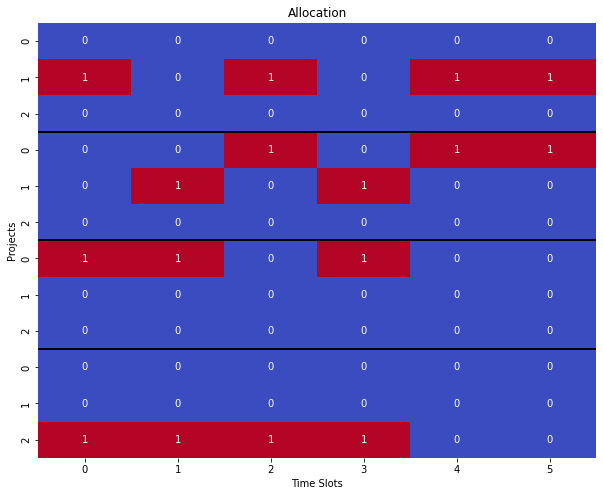

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
# Add lines for separation
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='g', cbar=False)
group_end_indices = [3, 6, 9]  # Adjust this based on your data
for index in group_end_indices:
    plt.axhline(y=index, color='black', linewidth=2)

# Adding titles and labels for clarity
plt.title('Allocation')
plt.xlabel('Time Slots')
plt.ylabel('Projects')

plt.show()

In [167]:
for p in range(nb_projects):
    print(f"project {p} : S", S[p].solution_value(), " F:",F[p].solution_value())

project 0 : S 2.0  F: 5.0
project 1 : S 1.0  F: 5.0
project 2 : S 5.0  F: 7.0
project 3 : S 0.0  F: 3.0
